In [1]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn import tree 
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
review_df = pd.read_json('https://data.cityofnewyork.us/resource/43nn-pn8j.json')

In [3]:
target='critical_flag'
review_df.head(3)

,action,bbl,bin,boro,building,camis,census_tract,community_board,council_district,critical_flag,...,latitude,longitude,nta,phone,record_date,score,street,violation_code,violation_description,zipcode
0,Violations were cited in the following area(s).,2.027350e+09,2005886.0,Bronx,925,50062594,8900.0,202.0,17.0,N,...,40.820427,-73.890985,BX27,3477084017,2019-11-03T06:00:35.000,11.0,HUNTS POINT AVE,10F,Non-food contact surface improperly constructe...,10459.0
1,Violations were cited in the following area(s).,3.067810e+09,3182482.0,Brooklyn,1821,40762828,55200.0,315.0,48.0,N,...,40.610180,-73.954941,BK44,7183398001,2019-11-03T06:00:35.000,22.0,KINGS HIGHWAY,08A,Facility not vermin proof. Harborage or condit...,11229.0
2,Violations were cited in the following area(s).,3.013350e+09,3393250.0,Brooklyn,1706,50001270,30900.0,308.0,36.0,N,...,40.677612,-73.934255,BK61,7187738200,2019-11-03T06:00:35.000,NaN,ATLANTIC AVE,16D,"Posted caloric content on the menu(s), menu bo...",11213.0


In [4]:
review_df.columns

Index(['action', 'bbl', 'bin', 'boro', 'building', 'camis', 'census_tract',
       'community_board', 'council_district', 'critical_flag',
       'cuisine_description', 'dba', 'grade', 'grade_date', 'inspection_date',
       'inspection_type', 'latitude', 'longitude', 'nta', 'phone',
       'record_date', 'score', 'street', 'violation_code',
       'violation_description', 'zipcode'],
      dtype='object')

# Remove Columns which will not be a meaningful contribution

Action must be removed for being a string with no discernable data.
Street is too varied to be used as dummy variable. 


In [5]:
# a method for quickly checking how many unique instances are in the dataframe,
# useful for determining if a column has too many variables to be a features.
def get_unique(column):
    return review_df[column].unique().shape[0]

In [6]:
get_unique('violation_description')

53

In [7]:
# Reassign all datetime columns as datetime
review_df['record_date'] = review_df['record_date'].astype('datetime64[ns]')
review_df['grade_date'] = review_df['grade_date'].astype('datetime64[ns]')
review_df['inspection_date'] = review_df['inspection_date'].astype('datetime64[ns]')

In [8]:
# splits all violation descriptions with commas to isolate individual phrases, plus their counts
def get_all_violations(review_df):
    all_violations = {}
    for violation in review_df['violation_description']:
        if type(violation) is str:
            split_violations = violation.split('.')
            for s in split_violations:
                if s in all_violations:
                    all_violations[s] += 1
                else:
                    all_violations[s] = 1
    return all_violations

In [9]:
# looks to see if the violation text contains one of the vermin, no return value. Just destructively changes dataframe
def add_violation_type(review_df, list_of_keywords, violation_name):
    total = 0
    for i, row in review_df.iterrows():
        violation = row['violation_description']
        if type(violation) is str:
            formatted = violation.lower()
            word_present = False
            # Go through each of the keywords and if the violation contains any of the keywords
            # row will get assigned 1
            for word in list_of_keywords:
                if word in formatted:
                    word_present = True
            if word_present:
                review_df.set_value(i, violation_name, 1)
                total += 1
            else:
                review_df.set_value(i, violation_name, 0)
    #print the amount changed as a side effect
    print(str(total) + ' violations found of ' + violation_name)

In [10]:
all_violations = get_all_violations(review_df)
count = 0
for violation in all_violations.keys():
#     print(violation)
    low_violation = violation.lower()
    if 'contamination' in low_violation:
        count += all_violations[violation]
print(count)

138


# Evaluating most popular words in the violation complaint

Find some of the most popular words in the violations, and then selectively (not including 'or's and 'the's) and make a column that states whether they are included in the complaint. These can be used as features later.

In [66]:
#find the most common words in all violations
from collections import Counter

counts = Counter()

for violation in all_violations.keys():
    counts.update(word.strip('.,?!"\'').lower() for word in violation.split())
    
sorted(dict(counts), key=dict(counts).get, reverse=True)[:15]



['or',
 'not',
 'food',
 'and',
 'in',
 'to',
 'posted',
 'of',
 'provided',
 'flies',
 'and/or',
 'for',
 'the',
 'is',
 'that']

In [65]:
#display list of the first 15 keys for inspection
list(all_violations.keys())[0:15]

['Non-food contact surface improperly constructed',
 ' Unacceptable material used',
 ' Non-food contact surface or equipment improperly maintained and/or not properly sealed, raised, spaced or movable to allow accessibility for cleaning on all sides, above and underneath the unit',
 '',
 'Facility not vermin proof',
 ' Harborage or conditions conducive to attracting vermin to the premises and/or allowing vermin to exist',
 'Posted caloric content on the menu(s), menu board(s), food tag(s) or stanchions adjacent to menu boards for drive-through windows deficient, in that the size and/or font for posted calories is not as prominent as the name of the menu item or its price',
 'Sanitized equipment or utensil, including in-use food dispensing utensil, improperly used or stored',
 "Live roaches present in facility's food and/or non-food areas",
 'Cold food item held above 41º F (smoked fish and reduced oxygen packaged foods above 38 ºF) except during necessary preparation',
 'Plumbing not p

In [13]:
def replace_critical_flag(review_df):
    for i, row in review_df.iterrows():
        # if a critical flag is positive, reassign as 1
        if row['critical_flag'] == 'Y':
            review_df.set_value(i, 'critical_flag', 1)
        elif row['critical_flag'] == 'N':
            review_df.set_value(i, 'critical_flag', 0)

In [14]:
# the list of vermin keywords that would assign a row as having that violation
vermin = ['rats', 'roaches', 'flies', 'mice', 'vermin']
contamination = ['contamination']
posted = ['posted']
provided = ['provided', 'properly']
add_violation_type(review_df, vermin, 'vermin')
add_violation_type(review_df, contamination, 'contamination')
add_violation_type(review_df, posted, 'posted')
add_violation_type(review_df, provided, 'provided')

review_df.dropna(axis=0,subset=[target, 'score'], inplace=True)
replace_critical_flag(review_df)
review_df[target] = review_df[target].astype(int)
review_df.columns


/Users/dsaphra/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/dsaphra/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  from ipykernel import kernelapp as app


281 violations found of vermin
138 violations found of contamination
28 violations found of posted
356 violations found of provided


/Users/dsaphra/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  import sys
/Users/dsaphra/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """


Index(['action', 'bbl', 'bin', 'boro', 'building', 'camis', 'census_tract',
       'community_board', 'council_district', 'critical_flag',
       'cuisine_description', 'dba', 'grade', 'grade_date', 'inspection_date',
       'inspection_type', 'latitude', 'longitude', 'nta', 'phone',
       'record_date', 'score', 'street', 'violation_code',
       'violation_description', 'zipcode', 'vermin', 'contamination', 'posted',
       'provided'],
      dtype='object')

In [15]:
# get_all_violations(review_df)

In [16]:
def get_all_low_unique(df):
    cols = df.columns
    low = []
    for col in cols:
        if get_unique(col) < 50 and get_unique(col) != 2:
            low.append(col)
            print(col+':'+str(get_unique(col)))

get_all_low_unique(review_df)

action:4
boro:5
grade:7
inspection_type:10
record_date:1
violation_code:41
violation_description:41


# Getting Dummies

Columns that can be discrete classifiers:

In [17]:
discrete_classifiers = {'violation_code', 'zipcode', 'boro', 'grade', 'inspection_type'}

def create_dummies(df, column):
    dummies = pd.get_dummies(review_df[column], prefix=column)
    new_df = df.join(dummies)
    new_df.drop(column, axis=1, inplace=True)
    return new_df

for feature in discrete_classifiers:
    review_df = create_dummies(review_df, feature)

In [18]:
get_unique('community_board')

62

In [60]:
removeable_features = [target, 'action', 'street', 'phone', 'latitude', 'longitude', 'nta', 
                       'camis', 'bin', 'building', 'dba', 'cuisine_description', 'bbl', 'census_tract',
                      'violation_description', 'grade_date', 'council_district', 'community_board', 'inspection_date', 'record_date']
features = list(review_df.columns)
for feature in removeable_features:
    features.remove(feature)
features[0:15]

['score',
 'vermin',
 'contamination',
 'posted',
 'provided',
 'zipcode_10001.0',
 'zipcode_10002.0',
 'zipcode_10003.0',
 'zipcode_10004.0',
 'zipcode_10005.0',
 'zipcode_10006.0',
 'zipcode_10007.0',
 'zipcode_10009.0',
 'zipcode_10010.0',
 'zipcode_10011.0']

In [20]:
def check_total_nas(df):
    total_nas = 0
    for col in df.columns:
        nas = df[col].isna().sum()
        if nas > 0:
            print(col, nas)
        total_nas += df[col].isna().sum()
    return total_nas



In [21]:
X = review_df[features]
# X.fillna(0)
y = review_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=234)

In [22]:
pd.set_option('display.max_columns', 200)
#check to make sure X has no nas contained
check_total_nas(X_train)

0

In [24]:
classifier = DecisionTreeClassifier(random_state=234)  
classifier.fit(X_train, y_train) 

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=234,
            splitter='best')

In [25]:
y_pred = classifier.predict(X_test)  

In [26]:
def display_accuracy(y_test, y_pred):
    # Calculate Accuracy 
    acc = accuracy_score(y_test,y_pred) * 100
    print("Accuracy is :{0}".format(acc))

    # Check the AUC for predictions
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print("\nAUC is :{0}".format(round(roc_auc,2)))

    # Create and print a confusion matrix 
    print('\nConfusion Matrix')
    print('----------------')
    pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)
    
display_accuracy(y_test, y_pred)

Accuracy is :98.94736842105263

AUC is :0.99

Confusion Matrix
----------------


In [27]:
# Train a DT classifier
classifier2 = DecisionTreeClassifier(random_state=10, criterion='entropy')  
classifier2.fit(X_train, y_train)  
# Make predictions for test data
y_pred = classifier2.predict(X_test)
display_accuracy(y_test, y_pred)

Accuracy is :99.47368421052632

AUC is :1.0

Confusion Matrix
----------------


In [28]:
# review_df[features].cov()

<Figure size 14400x576 with 0 Axes>

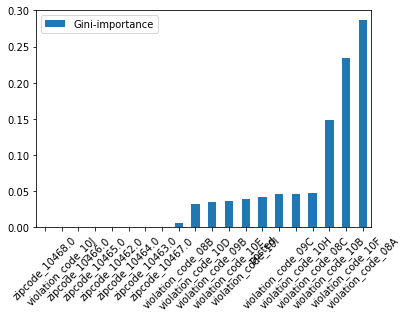

,Gini-importance
zipcode_10468.0,0.000000
violation_code_10J,0.000000
zipcode_10466.0,0.000000
zipcode_10465.0,0.000000
zipcode_10462.0,0.000000
zipcode_10464.0,0.000000
zipcode_10463.0,0.000000
zipcode_10467.0,0.000000
violation_code_08B,0.005456
violation_code_10D,0.032229


In [29]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train.columns, classifier.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
fig = plt.figure(figsize=(200,8))
importances.sort_values(by='Gini-importance')[-20:].plot(kind='bar', rot=45)
plt.show()
# The 10 most influential features for determining if a restaurant will be flagged

sorted_importances = importances.sort_values(by='Gini-importance')
sorted_importances[-20:]

In [30]:
feat_importances = classifier.feature_importances_

In [31]:
np.array([0.25544528, 0.00535936, 0.06769639, 0.01584299, 0.03423468,
       0.05960767, 0.00533303, 0.19870659, 0.00538589,
       0.02589597, 0.20431057, 0.05413907, 0.03777929, 0.03026322]).mean()

0.07142857142857142

In [32]:
def find_too_important_indeces(model ,thresh):
    feat_importances = classifier.feature_importances_
    too_import = []
    for i in range(len(feat_importances)):
        #.1 is our threshold for feature importance at this point, just getting rid of the worst offenders
        if feat_importances[i] > thresh:
            too_import.append(i)
            print(feat_importances[i])
    return too_import

#find the offending columns and store them into a list, to be excised later
def get_too_important_feats(model, thresh):
    too_import = find_too_important_indeces(model, thresh)
    too_import_feats = []
    for index in too_import:
        col_name = pd.DataFrame(X_train.iloc[:,index]).columns[0]
        print(col_name)
        too_import_feats.append(col_name)
    return too_import_feats

#remove features from model that have a feature_imporance greater than .09
def remove_too_important_feats(model, features, thresh):
    too_import_feats = get_too_important_feats(model, thresh)
    print(too_import_feats)
    for feat in too_import_feats:
        features.remove(feat)
    return features


In [33]:
features = remove_too_important_feats(classifier, features, .07)

0.28642586010327953
0.14812108432513543
0.2346203473945408
violation_code_08A
violation_code_10B
violation_code_10F
['violation_code_08A', 'violation_code_10B', 'violation_code_10F']


In [34]:
#redo the train-test split
X = review_df[features]
y = review_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=234)

#rebuild model with new less important features
classifier = DecisionTreeClassifier(random_state=234)  
classifier.fit(X_train, y_train) 

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=234,
            splitter='best')

<Figure size 14400x576 with 0 Axes>

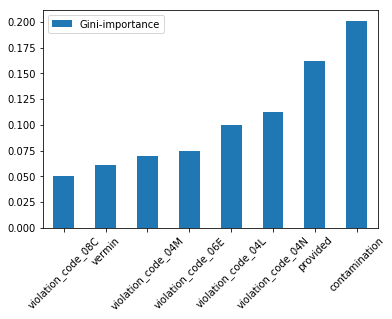

,Gini-importance
zipcode_10468.0,0.000000
zipcode_10462.0,0.000000
zipcode_10463.0,0.000000
zipcode_10464.0,0.000000
zipcode_10465.0,0.000000
zipcode_10466.0,0.000000
violation_code_05C,0.005439
violation_code_04K,0.020988
violation_code_04J,0.026354
violation_code_05D,0.034693


In [35]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train.columns, classifier.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
fig = plt.figure(figsize=(200,8))
importances.sort_values(by='Gini-importance')[-8:].plot(kind='bar', rot=45)
plt.show()
# The 10 most influential features for determining if a restaurant will be flagged

sorted_importances = importances.sort_values(by='Gini-importance')
sorted_importances[-20:]

In [36]:
y_pred = classifier.predict(X_test)  
display_accuracy(y_test, y_pred)

Accuracy is :99.47368421052632

AUC is :1.0

Confusion Matrix
----------------


In [37]:
features = remove_too_important_feats(classifier, features, .07)

0.2011941336426384
0.16194877748216072
0.09989540330926128
0.11278046257668772
0.07497859737894973
contamination
provided
violation_code_04L
violation_code_04N
violation_code_06E
['contamination', 'provided', 'violation_code_04L', 'violation_code_04N', 'violation_code_06E']


In [38]:
#redo the train-test split
X = review_df[features]
y = review_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=234)

#rebuild model with new less important features
classifier = DecisionTreeClassifier(random_state=234)  
classifier.fit(X_train, y_train) 

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=234,
            splitter='best')

In [39]:
y_pred = classifier.predict(X_test)  
display_accuracy(y_test, y_pred)


Accuracy is :78.94736842105263

AUC is :0.79

Confusion Matrix
----------------


<Figure size 14400x576 with 0 Axes>

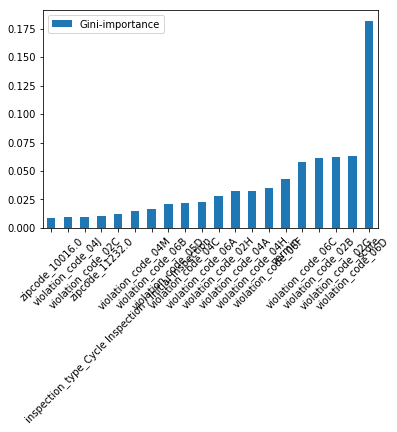

,Gini-importance
zipcode_10016.0,0.008612
violation_code_04J,0.009220
violation_code_02C,0.009654
zipcode_11232.0,0.010502
inspection_type_Cycle Inspection / Initial Inspection,0.012624
violation_code_04M,0.014892
violation_code_06B,0.016267
violation_code_05D,0.020726
violation_code_04C,0.021824
violation_code_06A,0.023019


In [40]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train.columns, classifier.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
fig = plt.figure(figsize=(200,8))
importances.sort_values(by='Gini-importance')[-20:].plot(kind='bar', rot=45)
plt.show()
# The 10 most influential features for determining if a restaurant will be flagged

sorted_importances = importances.sort_values(by='Gini-importance')
sorted_importances[-20:]

In [42]:
# Check the AUC of predictions
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.7899011299435028

# Improving Mod

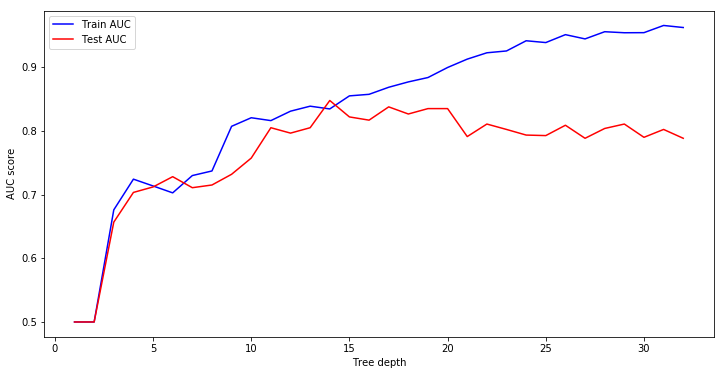

In [43]:
# Identify the optimal tree depth for given data
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   classifier = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
   classifier.fit(X_train, y_train)
   train_pred = classifier.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous train results
   train_results.append(roc_auc)
   y_pred = classifier.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous test results
   test_results.append(roc_auc)
plt.figure(figsize=(12,6))
plt.plot(max_depths, train_results, 'b', label='Train AUC')
plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.legend()
plt.show()

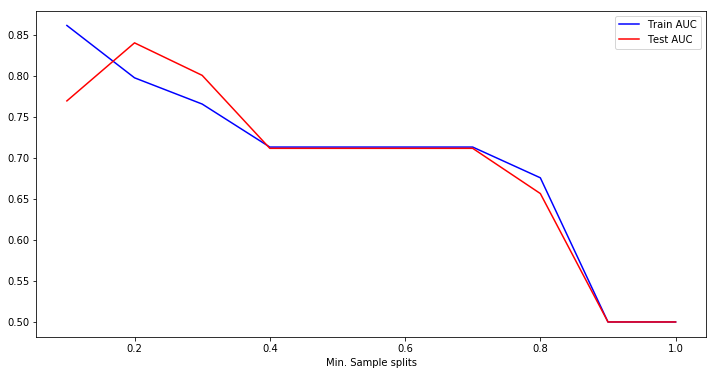

In [44]:
# Identify the optimal min-samples-split for given data
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
dt = classifier
for min_samples_split in min_samples_splits:
   dt = DecisionTreeClassifier(criterion='entropy', min_samples_split=min_samples_split)
   dt.fit(X_train, y_train)
   train_pred = dt.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds =    roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
plt.figure(figsize=(12,6))
plt.plot(min_samples_splits, train_results, 'b', label='Train AUC')
plt.plot(min_samples_splits, test_results, 'r', label='Test AUC')
plt.xlabel('Min. Sample splits')
plt.legend()
plt.show()

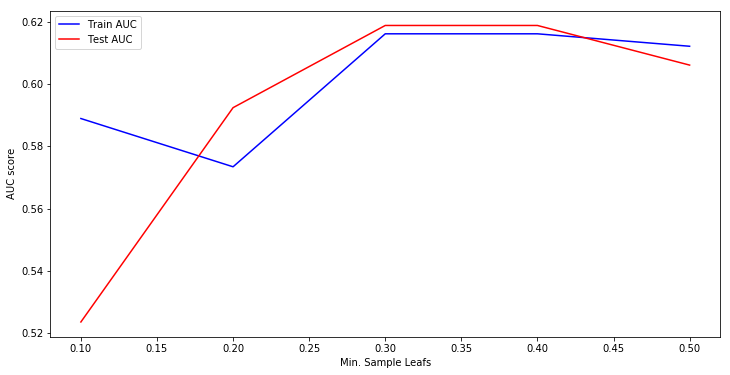

In [45]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
   dt = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=min_samples_leaf)
   dt.fit(X_train, y_train)
   train_pred = dt.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
    

plt.figure(figsize=(12,6))    
plt.plot(min_samples_leafs, train_results, 'b', label='Train AUC')
plt.plot(min_samples_leafs, test_results, 'r', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('Min. Sample Leafs')
plt.legend()
plt.show()  

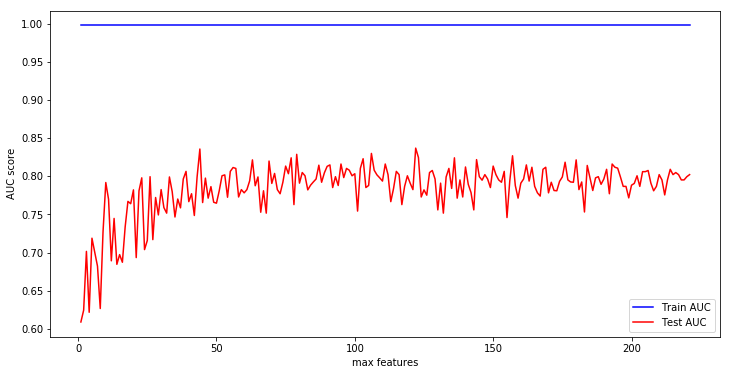

In [46]:
# Find the best value for optimal maximum feature size
max_features = list(range(1,X_train.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
   dt = DecisionTreeClassifier(criterion='entropy', max_features=max_feature)
   dt.fit(X_train, y_train)
   train_pred = dt.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

    
plt.figure(figsize=(12,6))
plt.plot(max_features, train_results, 'b', label='Train AUC')
plt.plot(max_features, test_results, 'r', label='Test AUC')

plt.ylabel('AUC score')
plt.xlabel('max features')
plt.legend()
plt.show() 

In [47]:
# train a classifier with optimal values identified above
dt = DecisionTreeClassifier(criterion='entropy',
                           max_features=8,
                           max_depth=10,
                           min_samples_split=0.5,
                           min_samples_leaf=0.4)
dt.fit(X_train, y_train)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.8022598870056498

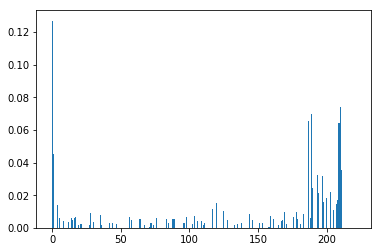

In [48]:
plt.bar(range(len(classifier.feature_importances_)), classifier.feature_importances_)
plt.show()

In [49]:
features = remove_too_important_feats(classifier, features, .09)
#redo the train-test split
X = review_df[features]
y = review_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=234)

#rebuild model with new less important features
classifier = DecisionTreeClassifier(random_state=234)  
classifier.fit(X_train, y_train) 

0.12694105990546178
score
['score']


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=234,
            splitter='best')

In [50]:
y_pred = classifier.predict(X_test)  
display_accuracy(y_test, y_pred)

Accuracy is :75.26315789473685

AUC is :0.77

Confusion Matrix
----------------


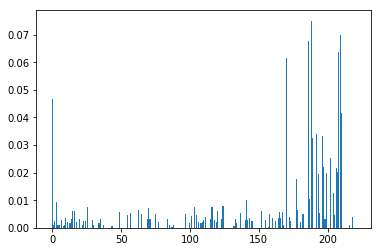

In [51]:
plt.bar(range(len(classifier.feature_importances_)), classifier.feature_importances_)
plt.show()

<Figure size 14400x576 with 0 Axes>

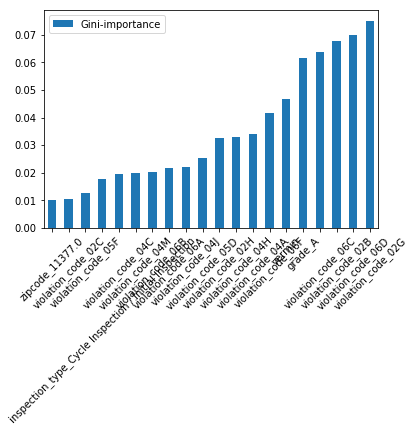

,Gini-importance
zipcode_11377.0,0.010172
violation_code_02C,0.010491
violation_code_05F,0.012583
inspection_type_Cycle Inspection / Initial Inspection,0.017719
violation_code_04C,0.019523
violation_code_04M,0.019876
violation_code_06B,0.020112
violation_code_06A,0.021603
violation_code_04J,0.022032
violation_code_05D,0.025431


In [52]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train.columns, classifier.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
fig = plt.figure(figsize=(200,8))
importances.sort_values(by='Gini-importance')[-20:].plot(kind='bar', rot=45)
plt.show()
# The 10 most influential features for determining if a restaurant will be flagged

sorted_importances = importances.sort_values(by='Gini-importance')
sorted_importances[-20:]

# Violation Code Definitions:

    06D -> Food contact surface not sanitized; and/or not clean to sight and/or touch
    02G -> Cold potentially hazardous food not held at 41°F or below
    06C -> Food not protected from contamination
    02B -> Hot potentially hazardous food not held at 140°F or above
    02H -> Potentially hazardous food not cooled by approved method 
    06E -> In-use food dispensing utensil not properly stored 

In [53]:
sorted_importances.reset_index(inplace=True)

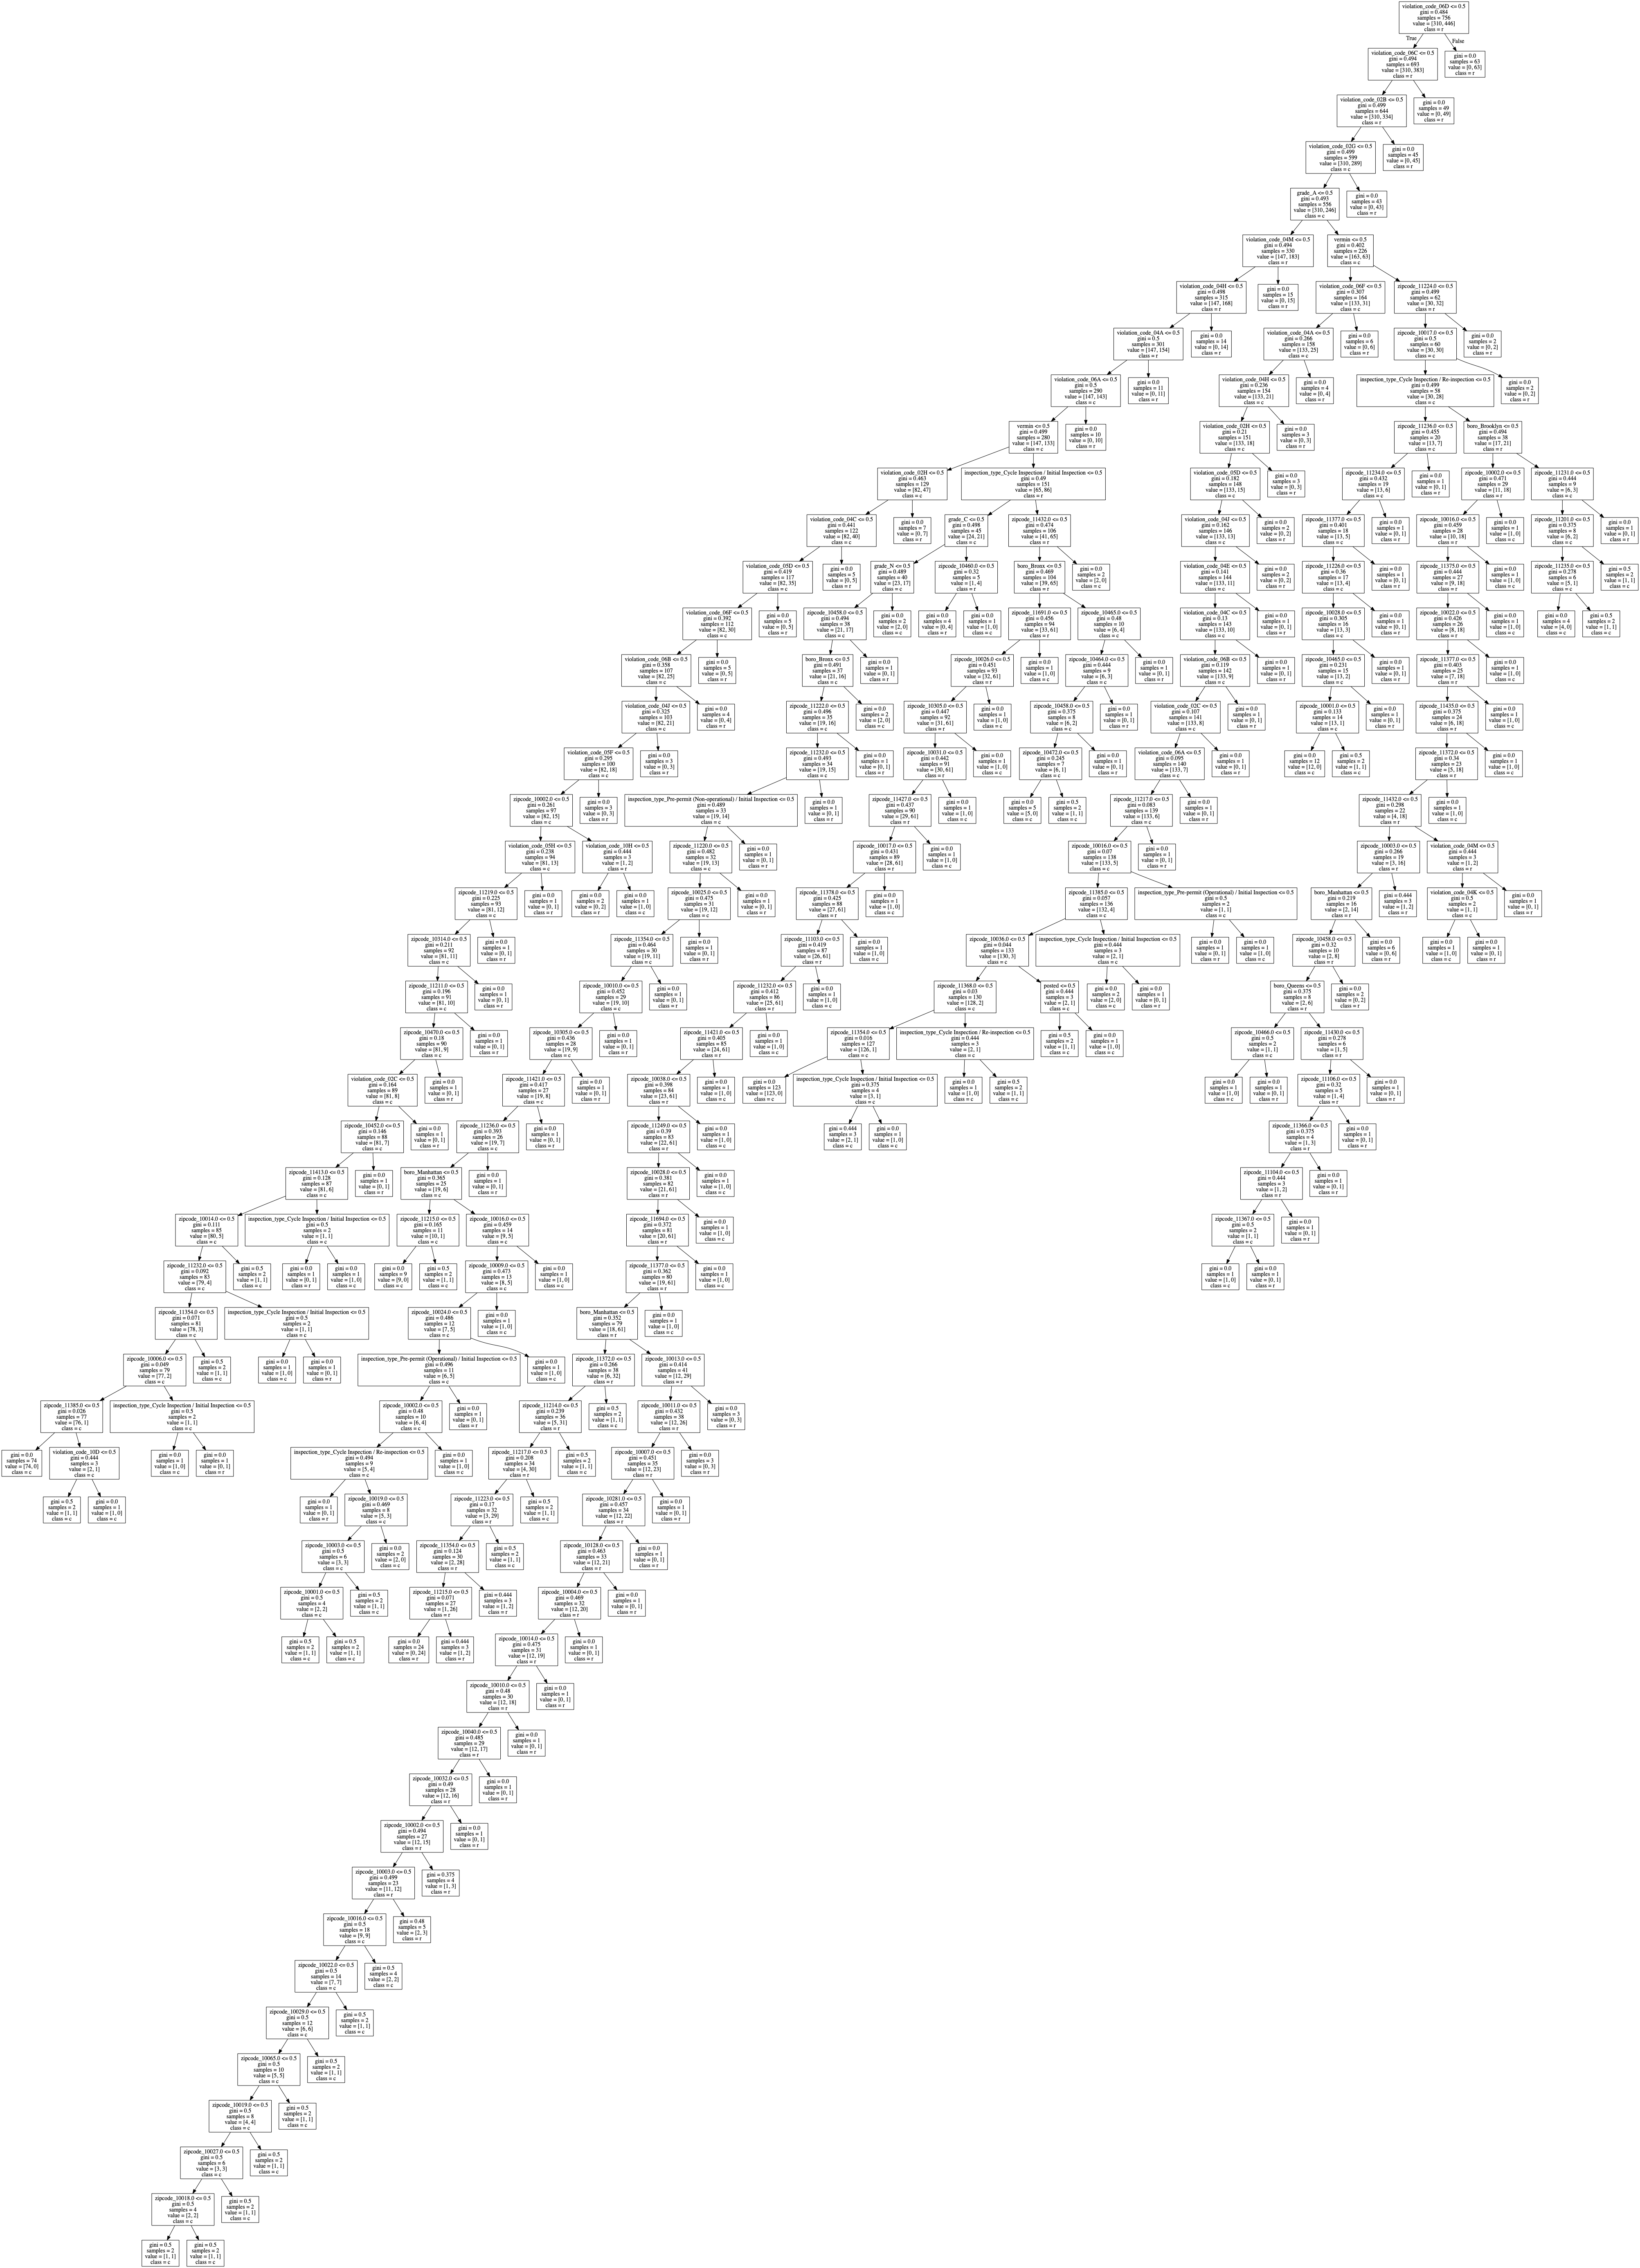

In [54]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from graphviz import Graph
# Create DOT data
dot_data = tree.export_graphviz(classifier, out_file=None, 
                                feature_names=X_train.columns,  
                                class_names='critical_flag')

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())
